# windpowerlib wind Example
This notebook demonstrates how to use the wind generation method that is based on windpowerlib to simulate the wind generation for multiple setups.

## Imports
Import required libraries and set visualization defaults.

In [1]:
import json
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from entise.constants import Types, Columns as C
from entise.core.generator import TimeSeriesGenerator as TSGen
%matplotlib inline

## Load Data
We load the wind turbine parameters from `objects.csv` and simulation data from the `data` folder. This includes weather data (CSV) and system configuration (JSON).

In [2]:
cwd = "."  # Current working directory: change if your kernel is not running in the same folder
objects = pd.read_csv(os.path.join(cwd, "objects.csv"))
data = {}
common_data_folder = "../common_data"
for file in os.listdir(os.path.join(cwd, common_data_folder)):
    if file.endswith(".csv"):
        name = file.split(".")[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, common_data_folder, file)), parse_dates=True)
data_folder = "data"
for file in os.listdir(os.path.join(cwd, data_folder)):
    if file.endswith(".csv"):
        name = file.split(".")[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, data_folder, file)), parse_dates=True)
    if file.endswith(".json"):
        name = file.split(".")[0]
        with open(os.path.join(os.path.join(cwd, data_folder, file)), "r") as f:
            data[name] = json.load(f)

print("Loaded data keys:", list(data.keys()))

Loaded data keys: ['weather', 'system']


## Instantiate and Configure Model
Initialize the time series generator and add the wind turbine objects.

In [3]:
gen = TSGen()
gen.add_objects(objects)

## Run the Simulation
Generate sequential wind power generation time series for each wind turbine object.

In [4]:
summary, df = gen.generate(data, workers=1)

100%|██████████| 8/8 [00:01<00:00,  4.28it/s]


## Results Summary
Below is a summary of the annual wind power generation, maximum generation and the full load hours of each wind turbine system.

In [5]:
print("Summary:")
summary_mwh = summary.copy()
summary_mwh['wind:generation[Wh]'] /= 1e6  # Convert Wh to MWh
summary_mwh['wind:maximum_generation[W]'] /= 1e6  # Convert W to MW
summary_mwh.columns = [col.replace("[W", "[MW") for col in summary_mwh.columns]
summary_mwh = summary_mwh.astype(float).round(2)
print(summary_mwh.to_string())

Summary:
          wind:generation[MWh]  wind:maximum_generation[MW]  wind:full_load_hours[h]
367791                 5013.17                         5.00                   1003.0
31991680               4339.10                         3.50                   1240.0
31991682               7553.99                         3.23                   2361.0
31991685               5546.11                         2.40                   2311.0
31991686               6533.08                         3.20                   2042.0
31991688               8848.21                         3.15                   2809.0
31991690                  0.00                         0.00                   2063.0
31991691              19343.28                         8.08                   2418.0


## Visualization of Results
Analyze wind power generation from various angles.

In [6]:
# Preparation
# Convert index to datetime for all time series
for obj_id in df:
    df[obj_id][Types.WIND].index = pd.to_datetime(df[obj_id][Types.WIND].index)

# Get turbine parameters from objects dataframe
system_configs = {}
for _, row in objects.iterrows():
    obj_id = row["id"]
    if obj_id in df:
        turbine_type = row["turbine_type"] if not pd.isna(row.get("turbine_type", pd.NA)) else "Default"
        hub_height = row["hub_height"] if not pd.isna(row.get("hub_height", pd.NA)) else "Default"
        power = row[C.POWER] if not pd.isna(row[C.POWER]) else 1
        system_configs[obj_id] = {"turbine_type": turbine_type, "hub_height": hub_height, "power": power}

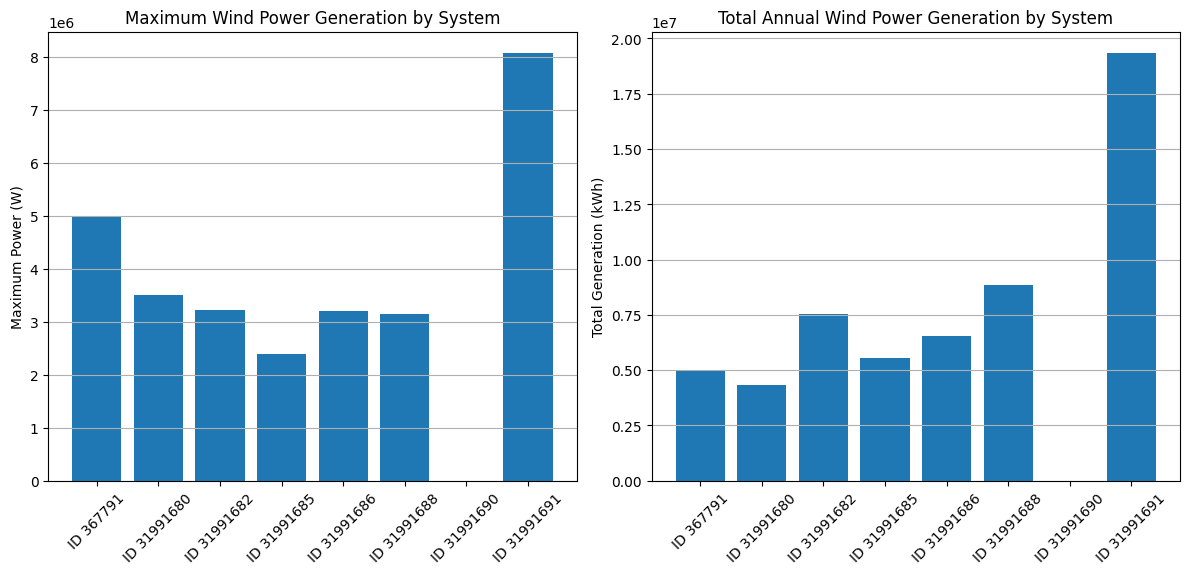

In [7]:
# Figure 1: Comparative analysis between different wind turbine systems
# Get the maximum generation for each system
max_gen = {}
total_gen = {}
for obj_id in df:
    # Extract scalar value from Series
    max_value = df[obj_id][Types.WIND].max()
    if hasattr(max_value, "iloc"):
        max_value = max_value.iloc[0]
    max_gen[obj_id] = max_value

    # Extract scalar value from Series
    total_value = df[obj_id][Types.WIND].sum() / 1000  # Convert to kWh
    if hasattr(total_value, "iloc"):
        total_value = total_value.iloc[0]
    total_gen[obj_id] = total_value

# Create a bar chart for maximum generation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(max_gen)), list(max_gen.values()), color="#1f77b4")
plt.xticks(range(len(max_gen)), [f"ID {id}" for id in max_gen.keys()], rotation=45)
plt.title("Maximum Wind Power Generation by System")
plt.ylabel("Maximum Power (W)")
plt.grid(axis="y")

# Create a bar chart for total generation
plt.subplot(1, 2, 2)
plt.bar(range(len(total_gen)), list(total_gen.values()), color="#1f77b4")
plt.xticks(range(len(total_gen)), [f"ID {id}" for id in total_gen.keys()], rotation=45)
plt.title("Total Annual Wind Power Generation by System")
plt.ylabel("Total Generation (kWh)")
plt.grid(axis="y")

plt.tight_layout()
plt.show()

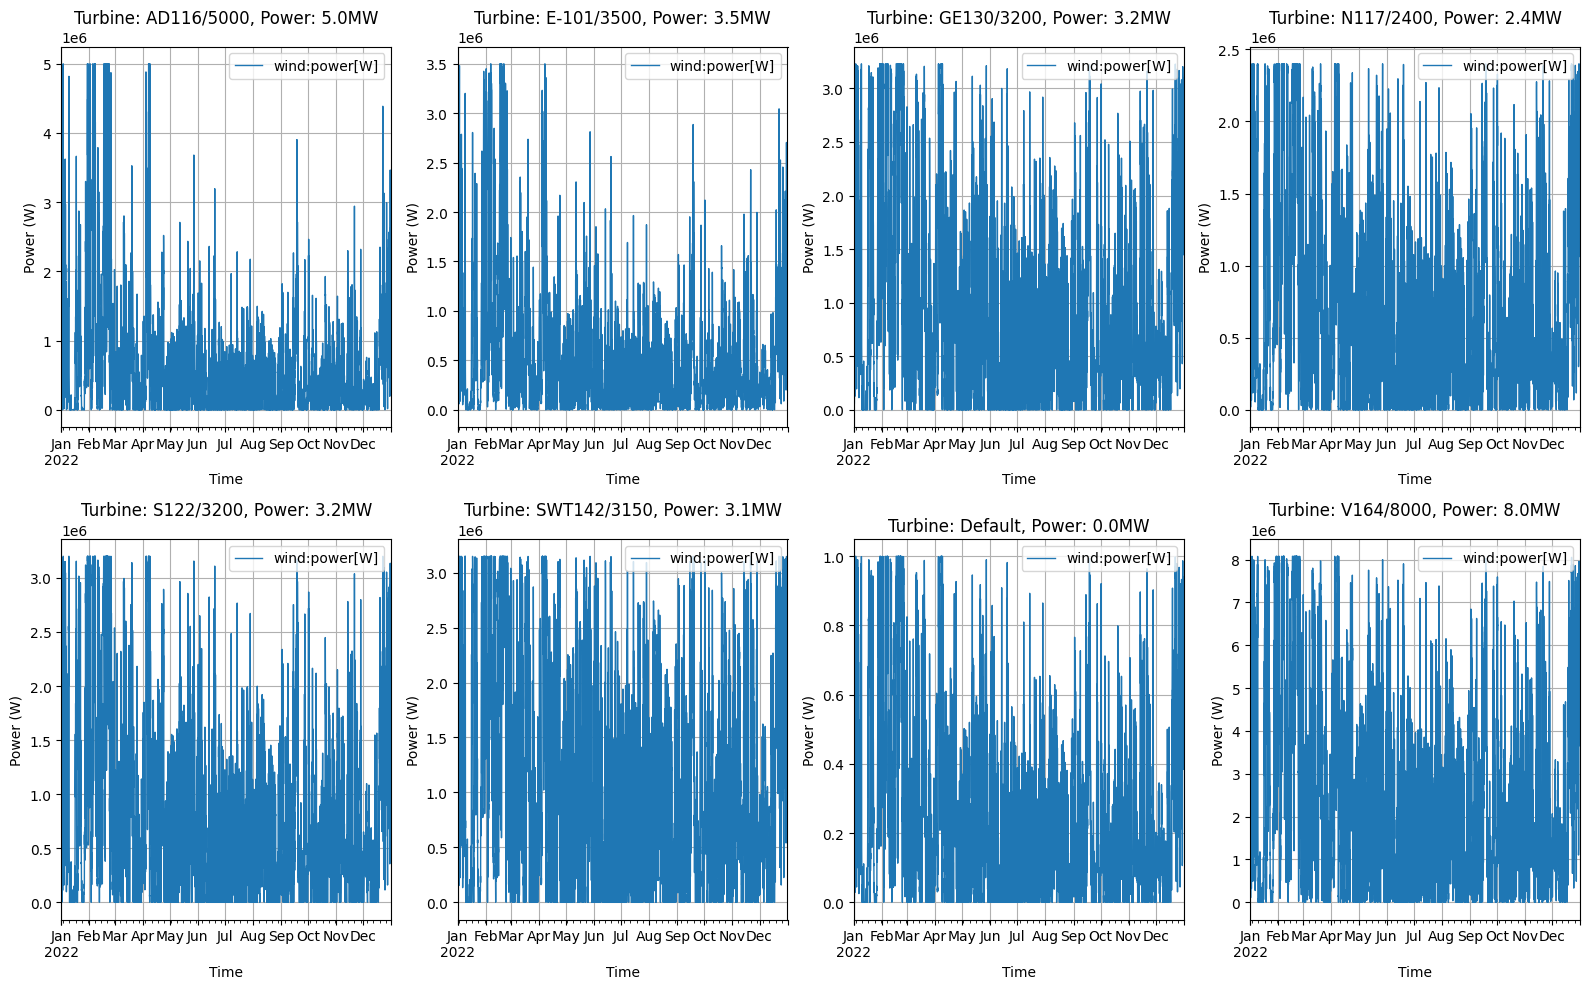

In [8]:
# Figure 2: Year timeseries visualization for all systems
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# For each wind turbine system, create a separate subplot
for i, obj_id in enumerate(df):
    # Get turbine parameters for the title
    turbine_type = system_configs[obj_id]["turbine_type"] if obj_id in system_configs else "Default"
    hub_height = system_configs[obj_id]["hub_height"] if obj_id in system_configs else "Default"
    power = system_configs[obj_id]["power"] if obj_id in system_configs else 1

    # Plot the time series
    df[obj_id][Types.WIND].plot(ax=axes[i], color="#1f77b4", linewidth=1)
    axes[i].set_title(f"Turbine: {turbine_type}, Power: {power/1e6:.1f}MW")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Power (W)")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


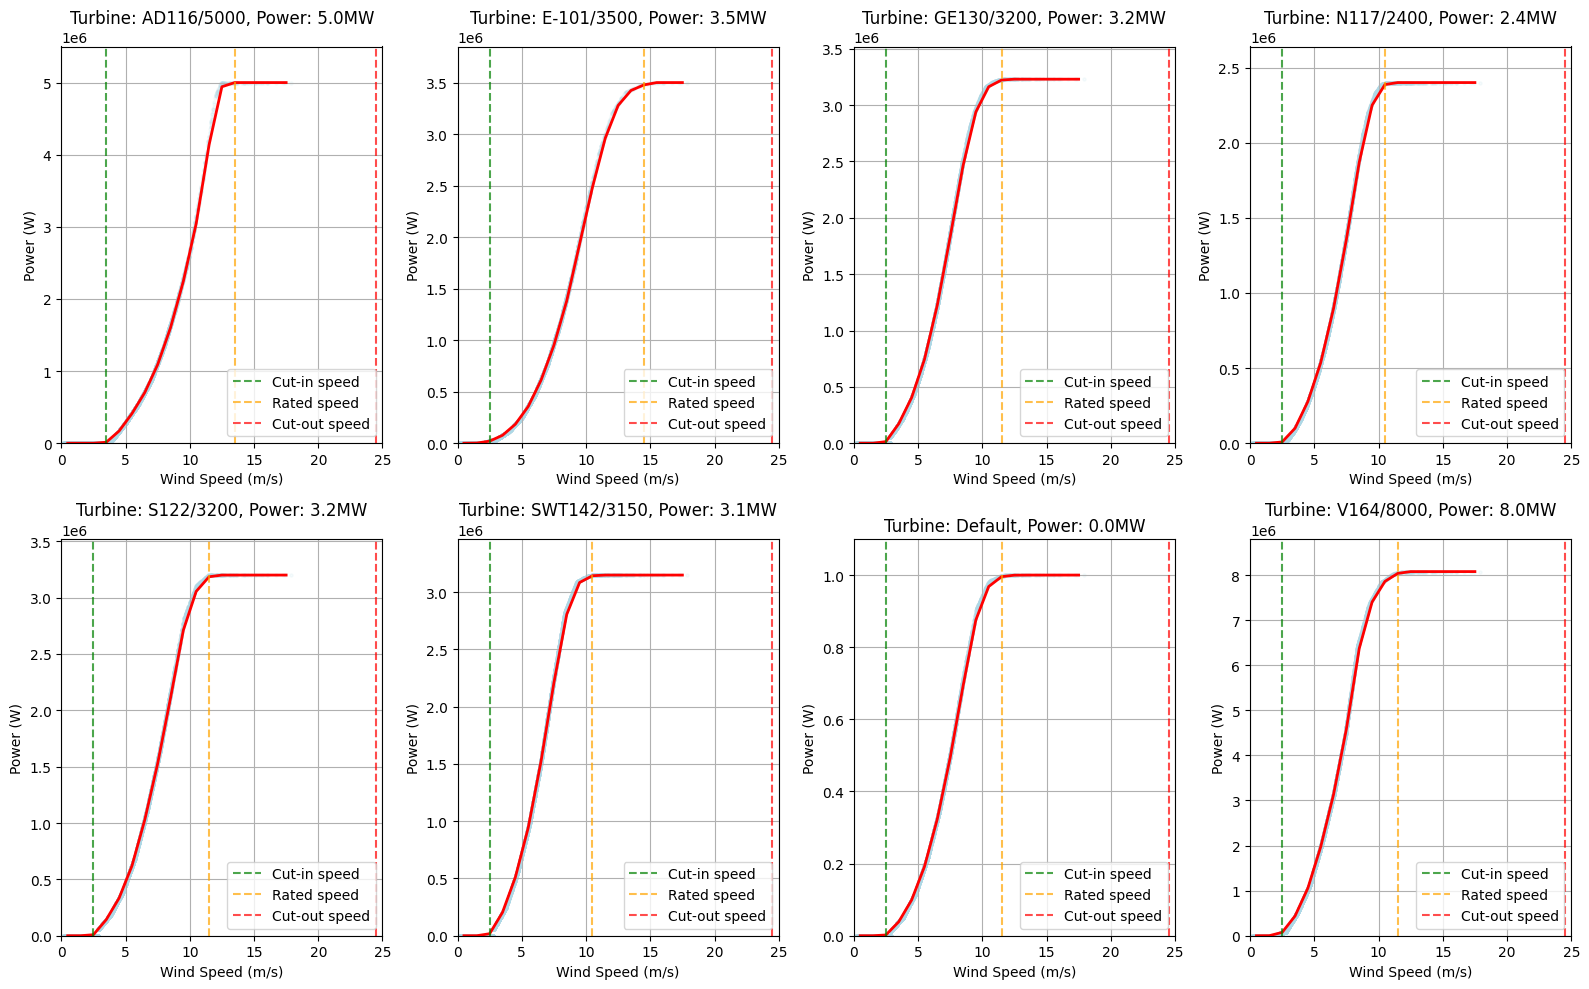

In [9]:
# Figure 3: Wind Power Curve Analysis
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# For each wind turbine system, create a separate subplot
for i, obj_id in enumerate(df):
    ts = df[obj_id][Types.WIND]

    # Get turbine parameters for the title
    turbine_type = system_configs[obj_id]["turbine_type"] if obj_id in system_configs else "Default"
    hub_height = system_configs[obj_id]["hub_height"] if obj_id in system_configs else "Default"
    power = system_configs[obj_id]["power"] if obj_id in system_configs else 1

    # Get the weather data
    weather_data = data["weather"].copy()
    weather_data["datetime"] = pd.to_datetime(weather_data["datetime"])
    weather_data.set_index("datetime", inplace=True)

    # Ensure the index is a DatetimeIndex
    if not isinstance(weather_data.index, pd.DatetimeIndex):
        weather_data.index = pd.to_datetime(weather_data.index, utc=True)

    # Resample weather data to hourly frequency
    weather_resampled = weather_data.resample("h").mean()

    # Merge power data with wind speed
    merged_data = pd.DataFrame({"power": ts.values.flatten()}, index=ts.index)
    merged_data["wind_speed"] = weather_resampled[f"{C.WIND_SPEED}@100m"]

    # Remove NaN values
    merged_data = merged_data.dropna()

    # Create bins for wind speed
    bins = np.linspace(0, 25, 26)  # 0 to 25 m/s in 1 m/s bins
    merged_data["wind_speed_bin"] = pd.cut(merged_data["wind_speed"], bins)

    # Calculate average power for each wind speed bin
    power_curve = merged_data.groupby("wind_speed_bin")["power"].mean()

    # Plot the power curve
    bin_centers = [(bin.left + bin.right) / 2 for bin in power_curve.index]
    axes[i].scatter(
        merged_data["wind_speed"], merged_data["power"], alpha=0.1, s=5, color="lightblue"
    )  # Raw data as scatter
    axes[i].plot(bin_centers, power_curve.values, "r-", linewidth=2)  # Average curve

    # Add vertical lines for cut-in, rated, and cut-out speeds based on power curve data
    # Find cut-in speed (last value where power is zero)
    power_values = list(power_curve.values)
    bin_centers_list = bin_centers

    # Find the last bin where power is close to zero (cut-in speed)
    cut_in_indices = [i for i, p in enumerate(power_values) if p < power * 0.01]
    cut_in_speed = bin_centers_list[cut_in_indices[-1]] if cut_in_indices else bin_centers_list[0]

    # Find the first bin where power reaches its maximum (rated speed)
    max_power = max(power_values)
    rated_indices = [i for i, p in enumerate(power_values) if p >= max_power * 0.99]
    rated_speed = bin_centers_list[rated_indices[0]] if rated_indices else bin_centers_list[-1]

    # Find the cut-out speed (where power drops significantly after reaching maximum)
    # First check if there are any points where power drops to near zero after reaching maximum
    if rated_indices:
        post_max_indices = [i for i in range(len(power_values)) if i > rated_indices[0]]
        cut_out_indices = [i for i in post_max_indices if power_values[i] < max_power * 0.01]
    else:
        # If there are no rated indices, there can't be any cut-out indices
        cut_out_indices = []

    if cut_out_indices:
        # If power drops to near zero after reaching maximum, use that as cut-out speed
        cut_out_speed = bin_centers_list[cut_out_indices[0]]
    else:
        # Otherwise, use the last bin center
        cut_out_speed = bin_centers_list[-1]

    axes[i].axvline(x=cut_in_speed, color="green", linestyle="--", alpha=0.7, label="Cut-in speed")
    axes[i].axvline(x=rated_speed, color="orange", linestyle="--", alpha=0.7, label="Rated speed")
    axes[i].axvline(x=cut_out_speed, color="red", linestyle="--", alpha=0.7, label="Cut-out speed")

    axes[i].set_title(f"Turbine: {turbine_type}, Power: {power/1e6:.1f}MW")
    axes[i].set_xlabel("Wind Speed (m/s)")
    axes[i].set_ylabel("Power (W)")
    axes[i].grid(True)
    axes[i].legend()

    # Set x and y limits
    axes[i].set_xlim(0, 25)
    axes[i].set_ylim(0, power * 1.1)

plt.tight_layout()
plt.show()

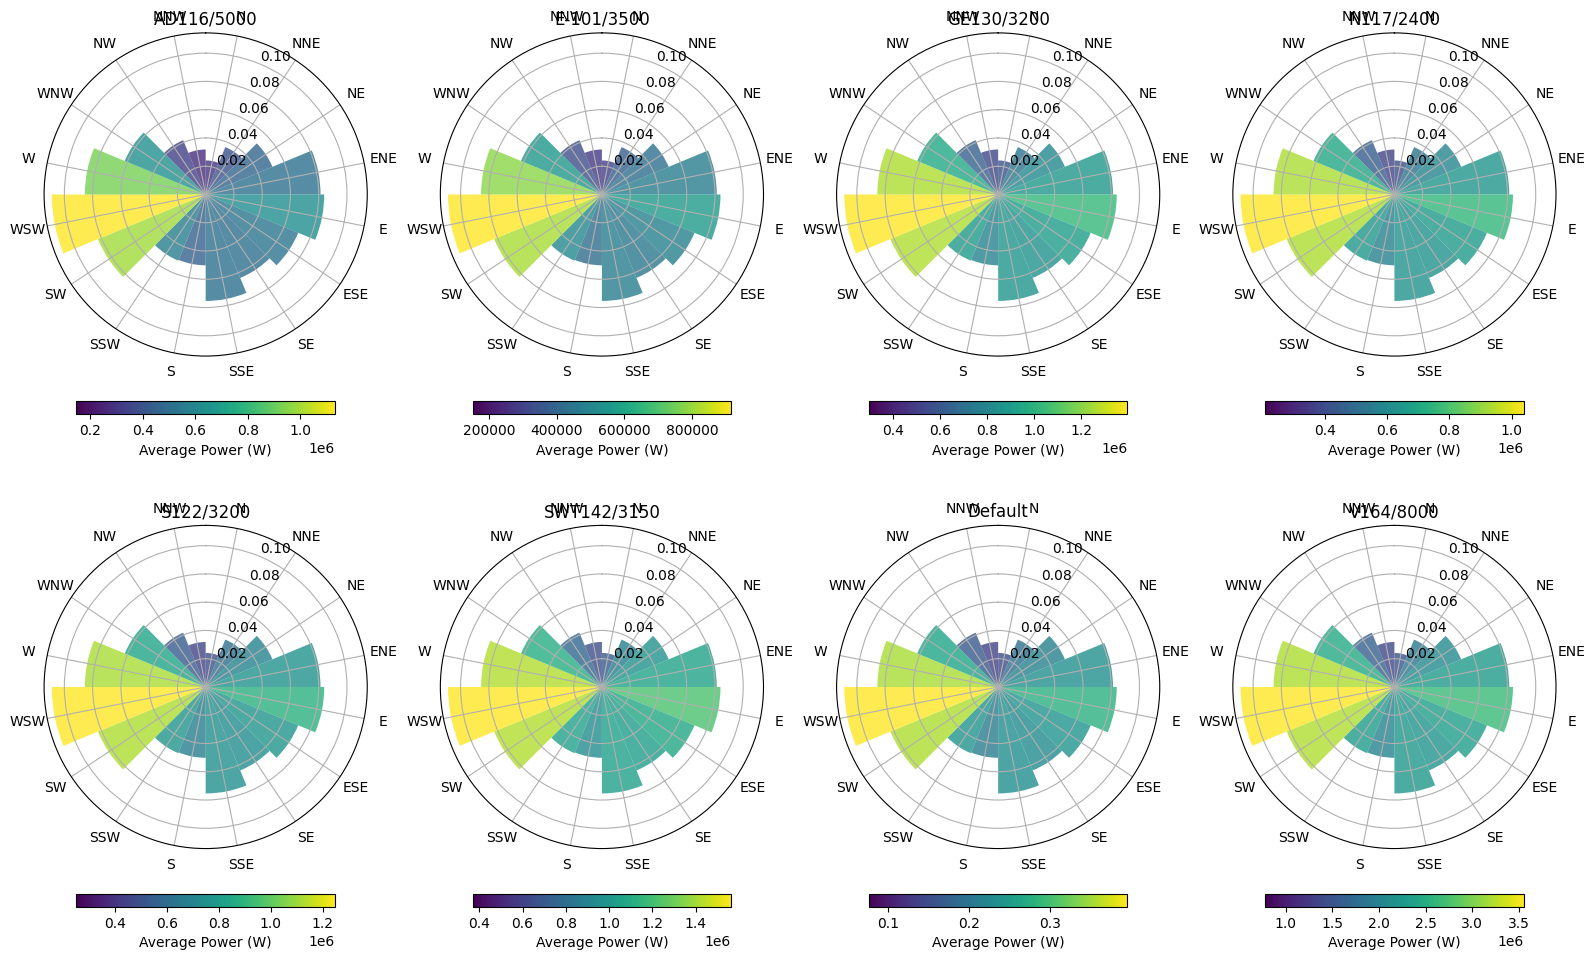

In [10]:
# Figure 4: Wind Rose with Power Generation
fig, axes = plt.subplots(2, 4, figsize=(16, 10), subplot_kw={"projection": "polar"})
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Define direction bins (16 directions)
dir_bins = np.linspace(0, 2 * np.pi, 17)
dir_centers = (dir_bins[:-1] + dir_bins[1:]) / 2
dir_labels = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]

# For each wind turbine system, create a separate subplot
for i, obj_id in enumerate(df):
    ts = df[obj_id][Types.WIND]

    # Get turbine parameters for the title
    turbine_type = system_configs[obj_id]["turbine_type"] if obj_id in system_configs else "Default"
    hub_height = system_configs[obj_id]["hub_height"] if obj_id in system_configs else "Default"
    power = system_configs[obj_id]["power"] if obj_id in system_configs else 1

    # Get the weather data
    weather_data = data["weather"].copy()
    weather_data["datetime"] = pd.to_datetime(weather_data["datetime"])
    weather_data.set_index("datetime", inplace=True)

    # Ensure the index is a DatetimeIndex
    if not isinstance(weather_data.index, pd.DatetimeIndex):
        weather_data.index = pd.to_datetime(weather_data.index, utc=True)

    # Resample weather data to hourly frequency
    weather_resampled = weather_data.resample("H").mean()

    # Merge power data with wind direction
    merged_data = pd.DataFrame({"power": ts.values.flatten()}, index=ts.index)
    merged_data["wind_direction"] = weather_resampled[f"{C.WIND_DIRECTION}@100m"]
    merged_data["wind_speed"] = weather_resampled[f"{C.WIND_SPEED}@100m"]

    # Remove NaN values
    merged_data = merged_data.dropna()

    # Convert wind direction from degrees to radians
    merged_data["wind_direction_rad"] = np.radians(merged_data["wind_direction"])

    # Create direction bins
    merged_data["direction_bin"] = pd.cut(
        merged_data["wind_direction_rad"], bins=dir_bins, labels=False, include_lowest=True
    )

    # Calculate frequency and average power for each direction bin
    direction_stats = merged_data.groupby("direction_bin").agg(
        frequency=("power", "count"), avg_power=("power", "mean"), avg_speed=("wind_speed", "mean")
    )

    # Normalize frequency
    direction_stats["frequency"] = direction_stats["frequency"] / direction_stats["frequency"].sum()

    # Normalize power for color scale
    norm_power = direction_stats["avg_power"] / direction_stats["avg_power"].max()

    # Create the wind rose
    bars = axes[i].bar(
        dir_centers, direction_stats["frequency"], width=np.diff(dir_bins)[0], bottom=0.0, align="center", alpha=0.8
    )

    # Color the bars according to average power
    cmap = plt.cm.viridis
    for j, bar in enumerate(bars):
        if j < len(norm_power):
            bar.set_facecolor(cmap(norm_power.iloc[j]))

    # Set the direction labels
    axes[i].set_theta_zero_location("N")
    axes[i].set_theta_direction(-1)  # Clockwise
    axes[i].set_thetagrids(np.degrees(dir_centers), dir_labels)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(direction_stats["avg_power"].min(), direction_stats["avg_power"].max())
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[i], orientation="horizontal", pad=0.1, shrink=0.8)
    cbar.set_label("Average Power (W)")

    axes[i].set_title(f"{turbine_type}")

plt.tight_layout()
plt.show()

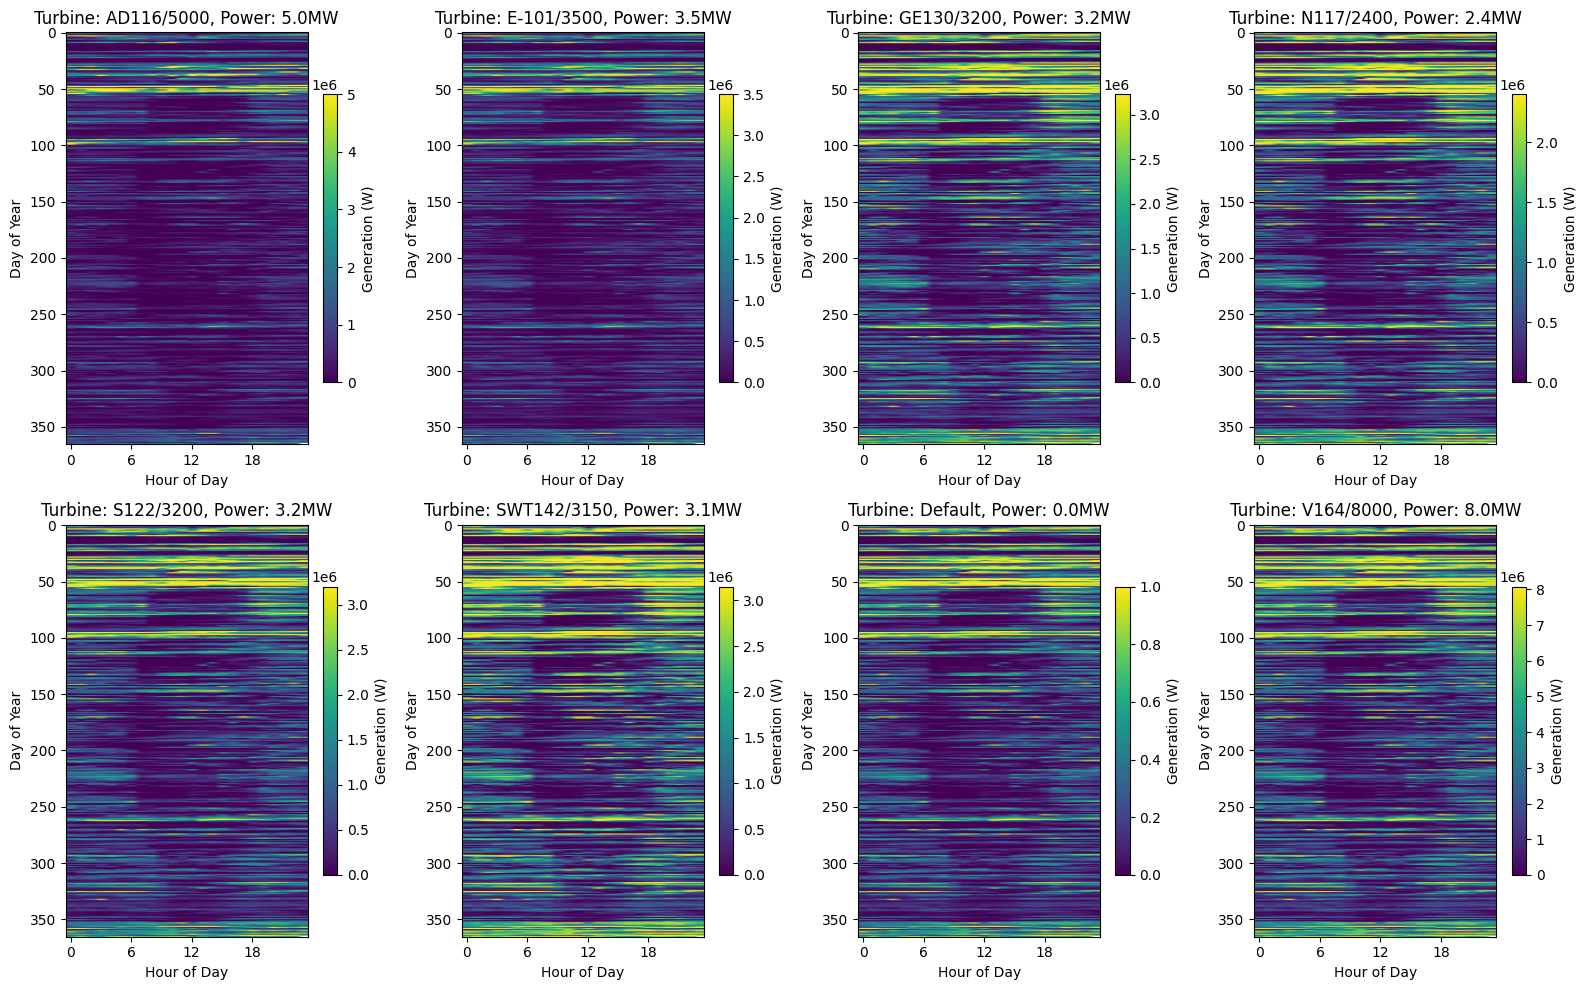

In [11]:
# Figure 5: Heatmap of daily generation patterns
# Create a figure with 8 subfigures (2x4 grid)
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# For each wind turbine system, create a separate subplot
for i, obj_id in enumerate(df):
    ts = df[obj_id][Types.WIND]

    # Get turbine parameters for the title
    turbine_type = system_configs[obj_id]["turbine_type"] if obj_id in system_configs else "Default"
    hub_height = system_configs[obj_id]["hub_height"] if obj_id in system_configs else "Default"
    power = system_configs[obj_id]["power"] if obj_id in system_configs else 1

    # Create a pivot table with hours as columns and days as rows
    # First resample to hourly frequency to ensure we have only one value per hour
    hourly_data = ts.resample("h").mean()

    # Create MultiIndex with date and hour
    daily_data = hourly_data.copy()
    daily_data.index = pd.MultiIndex.from_arrays([daily_data.index.date, daily_data.index.hour], names=["date", "hour"])

    # Drop any remaining duplicates (just to be safe)
    daily_data = daily_data[~daily_data.index.duplicated(keep="first")]

    # Unstack to create pivot table
    daily_pivot = daily_data.unstack(level="hour")

    # Create heatmap
    im = axes[i].imshow(daily_pivot, aspect="auto", cmap="viridis")
    axes[i].set_title(f"Turbine: {turbine_type}, Power: {power/1e6:.1f}MW")
    axes[i].set_xlabel("Hour of Day")
    axes[i].set_ylabel("Day of Year")
    axes[i].set_xticks(range(0, 24, 6))  # Show fewer ticks for readability

    # Add colorbar to each subplot
    fig.colorbar(im, ax=axes[i], shrink=0.7, label="Generation (W)")

plt.tight_layout()
plt.show()

## Next Steps
You can further explore:
- Adjusting wind turbine parameters in `objects.csv` (e.g., turbine_type, hub_height, power)
- Modifying the system configuration in `data/system.json` to test different wind models
- Analyzing the correlation between wind speed and power generation
- Comparing different turbine types and their performance characteristics
- Automating analysis for larger wind farm datasets
